# Train a multi-orthography character-level GPT to evaluate the phonemic transparency of a spelling system

This is a new version of OTEANN (c.f.https://arxiv.org/abs/1912.13321) using a minimalist GPT (from https://github.com/karpathy/minGPT.git).

Regarding he input data:
* It has been extracted from wiktionary.org (licence https://creativecommons.org/licenses/by-sa/3.0/)
* The train file contains around 68000 samples
 * (2000 "read" and 2000 "write" samples for each of the 17 orthographies).
* The test file contains 3400 samples
 * (100 "read" and 100 "write" samples for each of the 17 orthographies).

A single GPT-based model is trained on a multi-orthography CSV file.
The model is then tested for each orthography and for each task ("read" and "write").

Learning time is about 20 minutes on a 4-GPU machine.

In [1]:
!wget -q -N https://fonétik.fr/oteann2/oteann_2100_test.csv
!wget -q -N https://fonétik.fr/oteann2/oteann_2100_train.csv

In [2]:
!head oteann_2100_train.csv 

de,write,pʁivatleʁɐ,privatlehrer
ru,read,отбурившись,ɐdbʊrɪfʂɨs
de,read,frostempfindliche,fʁɔstɛmpfɪntlɪçə
nl,read,kwelder,kʋɛldər
ko,read,사령서,sʰaɾjʌ̹ŋsʰʌ̹
fr,write,mɛʁdujɛ,merdouillais
de,read,entrindeter,ɛntʁɪndətɐ
fi,read,nuolenpää,nuolempæː
pt,write,pɨzaʒɐ̃j̃,pesagem
tr,read,maskanyin,maskanjɪn


In [3]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.ERROR,
)

In [4]:
import datetime
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mingpt.model import GPT, GPTConfig
from mingpt.trainer import Trainer, TrainerConfig
from mingpt.utils import sample

In [5]:
# make deterministic
from mingpt.utils import set_seed
set_seed(44)

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn import functional as F

In [7]:
# These first configuration parameters are hyperparameters that we will need to tune
CONFIG = {            
    'n_layer': 4, 
    'n_head': 4, 
    'n_embd': 304,
}

ROOT_DIR = os.getcwd()

# These other configuration parameters will not be tuned
def add_config(config): 
    config['languages'] = ['ent', 'eno','ar', 'br', 'de', 
                           'en', 'es', 'fi', 'fr', 'fro', 
                           'it', 'ko', 'nl', 'pt', 'ru', 
                           'sh', 'tr']
    config['n_train'] = 2000 # number of training samples per orthography
    config['n_test'] = 100 # number of tested samples per orthography
    config['n_samples'] = config['n_train'] + config['n_test']
    config['label'] = 'oteann' + '_' + str(config['n_samples'])
    config['root_dir'] = ROOT_DIR    
    config['output_max_len'] = 25
    config['block_size'] = 63
    config['tasks'] = ['write', 'read']
    config['sep'] = ','
    config['features'] =  ['Language', 'Task', 'Input', 'Output']    
    config['trial_dir'] = os.getcwd() 
    config['trial_filename'] = config['trial_dir'] + '/' + config['label']
    config['train_filename'] = config['trial_filename'] + '_train.csv'
    config['test_filename'] = config['trial_filename'] + '_test.csv'
    config['model_filename'] = config['trial_filename'] + '_model.pt'
    config['results_filename'] = config['trial_filename'] + '_results.csv'
    return config
    
config = add_config(CONFIG)

In [8]:
import math
from torch.utils.data import Dataset

class CharDataset(Dataset):

    def __init__(self, data, block_size, debug=False):
        chars = sorted(list(set(data)))
        data_size, vocab_size = len(data), len(chars)
        if debug:
            print('data has %d characters, %d unique.' % (data_size, vocab_size))
        
        self.stoi = { ch:i for i,ch in enumerate(chars) }
        self.itos = { i:ch for i,ch in enumerate(chars) }
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.data = data
    
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        # grab a chunk of (block_size + 1) characters from the data
        chunk = self.data[idx:idx + self.block_size + 1]
        # encode every character to an integer
        dix = [self.stoi[s] for s in chunk]
        """
        arrange data and targets so that the first i elements of x
        will be asked to predict the i-th element of y. Notice that
        the eventual language model will actually make block_size
        individual predictions at the same time based on this data,
        so we are being clever and amortizing the cost of the forward
        pass of the network. So for example if block_size is 4, then
        we could e.g. sample a chunk of text "hello", the integers in
        x will correspond to "hell" and in y will be "ello". This will
        then actually "multitask" 4 separate examples at the same time
        in the language model:
        - given just "h", please predict "e" as next
        - given "he" please predict "l" next
        - given "hel" predict "l" next
        - given "hell" predict "o" next
        
        In addition, because the DataLoader will create batches of examples,
        every forward/backward pass during traning will simultaneously train
        a LOT of predictions, amortizing a lot of computation. In particular,
        for a batched input of integers X (B, T) where B is batch size and
        T is block_size and Y (B, T), the network will during training be
        simultaneously training to make B*T predictions, all at once! Of course,
        at test time we can paralellize across batch B, but unlike during training
        we cannot parallelize across the time dimension T - we have to run
        a forward pass of the network to recover the next single character of the 
        sequence along each batch dimension, and repeatedly always feed in a next
        character to get the next one.
        
        So yes there is a big asymmetry between train/test time of autoregressive
        models. During training we can go B*T at a time with every forward pass,
        but during test time we can only go B at a time, T times, with T forward 
        passes.
        """
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        return x, y


In [9]:
def predict_pron(config, train_dataset, trainer, model, word):
    try:
        x = torch.tensor([train_dataset.stoi[s] for s in word], dtype=torch.long)[None,...].to(trainer.device)
        y = sample(model, x, config['output_max_len'], temperature=1.0, sample=True, top_k=10)[0]
        completion = ''.join([train_dataset.itos[int(i)] for i in y])
    except:
        e = sys.exc_info()[0]
        print('predict_pron(): error %s for word:%s' % (e, word))
        # Typically, this can happen if a tested word contains a char
        # that did not existing during the training step
        completion = 'N/A'
    return completion

In [10]:
def train(config):

    training_t0 = datetime.datetime.now()  
    
    block_size = config['block_size']
    
    print("config['train_filename']:", config['train_filename'])        
    text = open(config['train_filename'], 'r').read() 
    train_dataset = CharDataset(text, block_size, debug=True) # one line is 63 characters

    # create model
    mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,
                      n_layer=config['n_layer'], 
                      n_head=config['n_head'], 
                      n_embd=config['n_embd'])

    model = GPT(mconf)

    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('ANN parameters: %d' % pytorch_total_params)
    
    # train model
    tconf = TrainerConfig(max_epochs=2, batch_size=256, learning_rate=6e-4,
                          lr_decay=True, warmup_tokens=512*20, 
                          final_tokens=2*len(train_dataset)*block_size,
                          num_workers=4)
    trainer = Trainer(model, train_dataset, None, tconf)
    trainer.train()
    training_t1 = datetime.datetime.now()  
    training_duration = training_t1 - training_t0
    print('training_duration', training_duration)
    
    torch.save(model.state_dict(), config['model_filename'])
    
    return model

In [11]:
def get_model(config):
    # following two lines are copied from train()
    block_size = config['block_size']
    text = open(config['train_filename'], 'r').read() # don't worry we won't run out of file handles
    train_dataset = CharDataset(text, config['block_size']) # one line of poem is roughly 50 characters
                       
    mconf = GPTConfig(train_dataset.vocab_size, train_dataset.block_size,                       
                      n_layer=config['n_layer'], 
                      n_head=config['n_head'], 
                      n_embd=config['n_embd'])
    model = GPT(mconf)
    model.load_state_dict(torch.load(config['model_filename']))
    model.eval()
    return model

In [12]:
def test(config, task, language, df_results, debug=False):
    
    model = get_model(config)
    
    # followwing two lines are copied from train()
    block_size = config['block_size']
    text = open(config['train_filename'], 'r').read() # don't worry we won't run out of file handles
    train_dataset = CharDataset(text, block_size) # one line of poem is roughly 50 characters

    
    tconf = TrainerConfig(max_epochs=2, batch_size=256, learning_rate=6e-4,
                          lr_decay=True, warmup_tokens=512*20, 
                          final_tokens=2*len(train_dataset)*block_size,
                          num_workers=4)
    trainer = Trainer(model, train_dataset, None, tconf)
    
    # test
    testing_t0 = datetime.datetime.now() 
    
    df_test = pd.read_csv(config['test_filename'], header=None, names=config['features'])    

    n = 0
    n_ok = 0
    n_ko = 0
    for index, row in df_test.iterrows():
        
        if row.Task != task or row.Language != language:
            continue
        
        n += 1
        
        # build the context 
        context = language + ',' + task + ',' + row.Input + ','
        
        # get the predicted output string
        prediction_padded = predict_pron(config, train_dataset, trainer, model, context)
        
        # identify where the interesting output is in the raw output
        if prediction_padded.startswith(context):
            
            # remove unwanted prefix
            prediction_padded = prediction_padded[len(context):]     
            
            # remove unwanted postfix (i.e. remove padding)
            eos = prediction_padded.find('\n', 1)
            if eos < 0:
                n_ko += 1
            else:
                prediction = prediction_padded[:eos]
                target = row.Output
                # check if prediction is same as target
                if prediction == target:
                    n_ok += 1
                else:
                    if debug and language != 'eno':
                        print('language:%s, target:%s, prediction:%s,' % (language, target, prediction))
                    n_ko += 1 
                # display the output (for the first test only)
                if n == 1:
                    if n_ok==1:
                        print('test-%d: %s "%s" in \'%s\' => prediction:"%s" (OK, target was:"%s")' % 
                              (n, task, row.Input, language, prediction, target))
                    if n_ko==1:
                        print('test-%d: %s "%s" in \'%s\' => prediction:"%s" (KO, target was:"%s")' % 
                              (n, task, row.Input, language, prediction, target))
                
        else:
            n_ko += 1

    pctg_ok = int(n_ok/n*100)
    pctg_ko = 100 - pctg_ok
    print('%s %5s: n=%d, n_ok=%d, n_ko=%d => %%n_ok=%d%%' % (language, task, n, n_ok, n_ko, pctg_ok))
    testing_t1 = datetime.datetime.now()  
    test_duration = testing_t1 - testing_t0
    
    dict_res = {'lang': language, 'task':task, 'test_accuracy': n_ok/n}
    return dict_res

In [13]:
def train_and_tests(config):
    
    acc = -1.0
    # open the file for being able to append the results of this test
    # otherwise create a new one
    df_results = pd.DataFrame()
        
    # train the ANN for all available languages in the training dataset
    # i.e. multi-language training
    train(config)
        
    # test the ANN for each languages
    for language in config['languages']:
        for task in config['tasks']:
            dict_res = test(config, task, language, df_results)
            
            # put the results as a new line in the CSV history file
            df_res = pd.DataFrame(data = [dict_res.values()], columns = dict_res.keys())
            df_results = pd.concat([df_results, df_res], axis=0, ignore_index=True, sort=False)
            df_results.to_csv(config['results_filename'], index=None, header=True)
    
    # Return a mean accuracy over all tested orthographies.
    # This score may help comparing this trial with other ones having different hyperparameters
    acc = df_results.test_accuracy.mean()
    print('accuracy:%.2f' % acc)
    
    return df_results

In [14]:
df_results = train_and_tests(config)

config['train_filename']: /home/arc/minGPT/oteann_2100_train.csv
data has 1928919 characters, 287 unique.
ANN parameters: 4646032


  0%|          | 0/7535 [00:00<?, ?it/s]/home/arc/minGPT/mingpt/lib/python3.6/site-packages/torch/nn/parallel/_functions.py:61: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
epoch 1 iter 7534: train loss 0.94341. lr 3.000199e-04: 100%|██████████| 7535/7535 [08:48<00:00, 14.25it/s]
epoch 2 iter 7534: train loss 0.84648. lr 6.000000e-05: 100%|██████████| 7535/7535 [08:52<00:00, 14.15it/s]


training_duration 0:17:43.753647
test-1: write "ʌnwɪlɪŋ" in 'ent' => prediction:"ʌnwɪlɪŋ" (OK, target was:"ʌnwɪlɪŋ")
ent write: n=100, n_ok=96, n_ko=4 => %n_ok=96%
test-1: read "dɛzmɪd" in 'ent' => prediction:"dɛzmɪd" (OK, target was:"dɛzmɪd")
ent  read: n=100, n_ok=97, n_ko=3 => %n_ok=97%
test-1: write "tɛmpteɪʃən" in 'eno' => prediction:"fʌvæŋeɚ" (KO, target was:"ɾŋɹŋʊhtɪŋa")
eno write: n=100, n_ok=0, n_ko=100 => %n_ok=0%
test-1: read "ːθɑtɔkʍɛɲj" in 'eno' => prediction:"ɛkstɹəfæktəmi" (KO, target was:"njuːɡətɔɹi")
eno  read: n=100, n_ok=0, n_ko=100 => %n_ok=0%
test-1: write "tuħasˤinuːna" in 'ar' => prediction:"تُحَصِّنُوْنَ" (OK, target was:"تُحَصِّنُوْنَ")
ar write: n=100, n_ok=75, n_ko=25 => %n_ok=75%
test-1: read "رَصْد" in 'ar' => prediction:"rasˤd" (OK, target was:"rasˤd")
ar  read: n=100, n_ok=98, n_ko=2 => %n_ok=98%
test-1: write "zistãmʃɔt" in 'br' => prediction:"zistammjod" (OK, target was:"zistammjod")
br write: n=100, n_ok=73, n_ko=27 => %n_ok=73%
test-1: read "peurjon" 

/home/arc/minGPT/mingpt/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


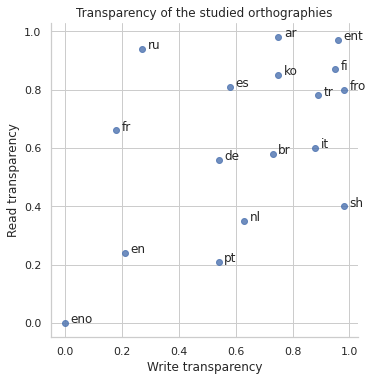

In [17]:
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))

def display_scatterplot_results(config):
    df_results = pd.read_csv(config['results_filename']) 
    df_w = df_results[df_results.task=='write']
    df_w.rename(columns={"task": "write"})
    df_r = df_results[df_results.task=='read']
    df_r.rename(columns={"task": "read"})

    df_res = df_w.merge(df_r, left_on='lang', right_on='lang')
    df_res = df_res.rename(columns={"test_accuracy_x": "write_accuracy", 
                                    "test_accuracy_y": "read_accuracy"})

    ax = sns.lmplot('write_accuracy', # Horizontal axis
           'read_accuracy', # Vertical axis
           data=df_res, # Data source
           fit_reg=False, # Don't fix a regression line
           height = 5,
           aspect = 1 ) # size and dimension

    plt.title('Transparency of the studied orthographies')
    # Set x-axis label
    plt.xlabel('Write transparency')
    # Set y-axis label
    plt.ylabel('Read transparency')

    label_point(df_res.write_accuracy, df_res.read_accuracy, df_res.lang, plt.gca())
    
display_scatterplot_results(config)